## Imports

In [1]:
import pandas as pd
import numpy as np
import math
from scipy import stats

In [2]:
from collections import defaultdict

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

In [4]:
# Add path to book code
import os
import sys

sys.path.append( os.path.join( '.', 'original', 'code') )

In [5]:
from original.code import nsfg, analytic, brfss

## Data Source

In [6]:
df_orig = nsfg.ReadFemPreg('original/code/2002FemPreg.dct', 'original/code/2002FemPreg.dat.gz')
print(f'Shape : {df_orig.shape}')
df_orig.head()

Shape : (13593, 244)


,caseid,pregordr,howpreg_n,howpreg_p,moscurrp,nowprgdk,pregend1,pregend2,nbrnaliv,multbrth,...,laborfor_i,religion_i,metro_i,basewgt,adj_mod_basewgt,finalwgt,secu_p,sest,cmintvw,totalwgt_lb
0,1,1,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,3410.389399,3869.349602,6448.271112,2,9,NaN,8.8125
1,1,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,3410.389399,3869.349602,6448.271112,2,9,NaN,7.8750
2,2,1,NaN,NaN,NaN,NaN,5.0,NaN,3.0,5.0,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,9.1250
3,2,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,7.0000
4,2,3,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,6.1875


In [7]:
# Focus on relevant columns
relevant_cols = ['caseid', 'prglngth', 'outcome', 'pregordr', 'birthord', 'birthwgt_lb', 'birthwgt_oz', 'agepreg', 'finalwgt']
preg = df_orig.loc[:, relevant_cols]  # Not using loc here will lead to SettingWithCopyWarning
                                    # since pandas will not be able to ascertain if df is a view or a copy
# Calculate Total Weight
preg['totalwgt_lb'] = preg.birthwgt_lb + preg.birthwgt_oz / 16.0
print(f'Shape: {preg.shape}')

Shape: (13593, 10)


In [8]:
# Respondents Data
resp = nsfg.ReadFemResp('original/code/2002FemResp.dct', 
                        'original/code/2002FemResp.dat.gz')

In [9]:
# Areas of focus
live = preg.loc[preg.outcome == 1]
firsts = live[live.birthord == 1]
others = live[live.birthord != 1]

In [10]:
baby_boom = analytic.ReadBabyBoom('original/code/babyboom.dat')

In [11]:
behave_risk = brfss.ReadBrfss(filename='original/code/CDBRFS08.ASC.gz')

## Useful Functions

In [12]:
def create_cdf(ser):
    return ser.value_counts(normalize=True).sort_index().cumsum()

In [13]:
def create_normal_model(values):
    return stats.norm(values.mean(), values.std())

In [14]:
# Normal Probability Plot
def normal_prob_plot(samples):
    n = len(samples)
    normal_samples = np.random.normal(0, 1, n)
    return np.sort(normal_samples), np.sort(samples)

In [15]:
# Pearson Median Skewness
def pearson_median_skewness(sample):
    median = np.median(sample)
    mean = sample.mean()
    std = sample.std()
    gp = 3*(mean - median) / std
    return gp

## Relationships between Variables

### Scatter Plot

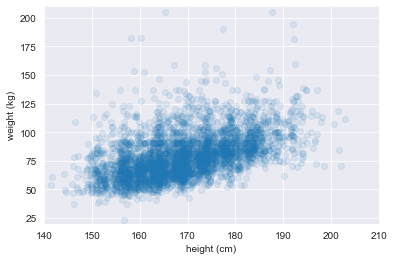

In [16]:
sample = behave_risk.sample(4000)
heights, weights = sample.htm3, sample.wtkg2
sns.regplot(x=heights, y=weights, 
            scatter_kws={'alpha':0.1}, fit_reg=False, 
            x_jitter=1.3, y_jitter=0.5) # regplot() has jitter options
                                        # scatterplot() jitter is non-functional
plt.xlim(140, 210);
plt.ylim(20, 210);
plt.xlabel('height (cm)')
plt.ylabel('weight (kg)');

### Hexbin Plot

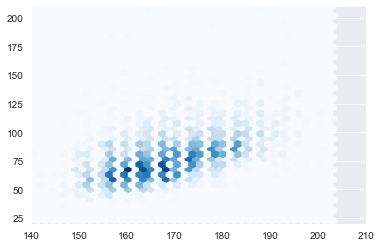

In [17]:
plt.hexbin(heights, weights, cmap='Blues', gridsize=50) # Unjittered
plt.xlim(140, 210);
plt.ylim(20, 210);

### Binning

In [18]:
df = behave_risk.dropna(subset=['wtkg2','htm3'])
bins = np.arange(135, 210, 5)
bin_indices = np.digitize(df.htm3, bins)
mean_heights = df.groupby(bin_indices)['htm3'].mean()

In [19]:
mean_heights

0     120.124590
1     135.785088
2     141.433962
3     146.337188
4     151.528440
5     156.350342
6     161.674210
7     166.569727
8     171.409542
9     176.549081
10    181.575961
11    186.324700
12    191.785971
13    196.642656
14    201.738272
15    210.587786
Name: htm3, dtype: float64